#### Initial Twitter analysis of DT and HC tweets during elections in hunt for adjectives use.

It's just first analysis, opening for 100 analysis challange.
Just getting started, keep watching the progress.

This is a bit basic, just:
- getting data from CSC
- a bit cleaning with lambdas, re and pandas
- stemming
- Spacy tokenizing for getting ADJECTIVES out of tweers
- Value counts
- Averages, proportion
- Horrible ugly plot at the end :)


In [80]:
import pandas as pd
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
import spacy

nlp = spacy.load('en_core_web_sm')

In [74]:
# Get tweets from CSV
tdb = pd.read_csv('thhk.csv') # 6k+ Hillary and Donald tweets available online
tdb.head(1)

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...


In [76]:
# Get tweet text without hashtags and links
tdb['spl'] = tdb['text'].str.split(' ')

tdb['ok'] = tdb['spl'].apply(lambda x: [word for word in x if not '@' in word])
tdb['ok'] = tdb['ok'].apply(lambda x: [word for word in x if not '#' in word])
tdb['ok'] = tdb['ok'].apply(lambda x: [word for word in x if not 'http' in word])
tdb['ok'] = tdb['ok'].str.join(' ')

# But save them
for s in ['@', '#', 'http']:
    tdb[s] = tdb['spl'].apply(lambda x: [word for word in x if s in word])
    
tdb['ok'].head(10)

0    The question in this election: Who can put the...
1    Last night, Donald Trump said not paying taxes...
2    Couldn't be more proud of Her vision and comma...
3    If we stand together, there's nothing we can't...
4    Both candidates were asked about how they'd co...
5    Join me for a 3pm rally - tomorrow at the Mid-...
6    This election is too important to sit out. Go ...
7       When Donald Trump goes low...register to vote:
8    Once again, we will have a government of, by a...
9    3) Has Trump offered a single proposal to redu...
Name: ok, dtype: object

In [77]:
# Clean string
def clean_string(text):
    return re.sub(r'[^a-zA-z0-9\s]', '', text)

# Update ok and split
tdb['ok'] = tdb['ok'].apply(lambda x: clean_string(x))
tdb['spl'] = tdb['ok'].str.split(' ')

for i, t in enumerate(tdb['ok'].tolist()):
    if i in range(128, 130):
        print(i,t)

128 A Clinton economy  more taxes and more spending
129 has been part of the rigged DC system for 30 years Why would we take policy advice from her


In [79]:
# Stem words
def porter_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    return ' '.join([ps.stem(word) for word in text.split()])

tdb['stemmed'] = tdb['ok'].apply(lambda x: porter_stemmer(x))

for i, t in enumerate(tdb['stemmed'].tolist()):
    if i in range(128, 130):
        print(i,t)

128 A clinton economi more tax and more spend
129 ha been part of the rig DC system for 30 year whi would we take polici advic from her


In [81]:
def get_Spacy_tags_for(pd_column):
    pos = []
    for doc in nlp.pipe(pd_column.astype('unicode').values, batch_size=50, n_threads=4):
        if doc.is_parsed:
            pos_seq = " ".join([n.pos_ for n in doc])
            pos.append(pos_seq)
        else:
            pos.append(None)
    return pos

# get part of speech for each word in each tweet
pd_column = tdb['ok']
tdb['pos'] = get_Spacy_tags_for(pd_column)

tdb.loc[:,['pos']].head(20)

,pos
0,DET NOUN ADP DET NOUN NOUN VERB VERB DET NOUN ...
1,ADJ NOUN PROPN PROPN VERB ADV VERB NOUN VERB A...
2,VERB ADV VERB ADV ADJ ADP ADJ NOUN CCONJ NOUN ...
3,ADP PRON VERB ADV ADV VERB NOUN PRON VERB ADV ...
4,DET NOUN VERB VERB ADP ADV PRON VERB VERB ADJ ...
5,VERB PRON ADP DET NUM NOUN NOUN SPACE NOUN ADP...
6,DET NOUN VERB ADV ADJ PART VERB PART VERB ADP ...
7,ADV PROPN PROPN VERB VERB PART VERB
8,ADV ADV PRON VERB VERB DET NOUN ADP ADP CCONJ ...
9,PUNCT VERB PROPN VERB DET ADJ NOUN PART VERB D...


In [82]:
# Count adjectives in each tweet according to POS model
tdb['ADJcnt'] = tdb['pos'].str.count('ADJ')
tdb['ADJcnt'].head(10)

0    2
1    3
2    6
3    2
4    2
5    0
6    2
7    0
8    0
9    1
Name: ADJcnt, dtype: int64

In [96]:
# Separate dataset into Donald and Hillary:
HillaryTweets = tdb[tdb['handle'].str.contains("Hillary")]
DonaldTweets = tdb[tdb['handle'].str.contains("Donald")]

# and count
for tweets in [[HillaryTweets,"Hillary"], [DonaldTweets, "Donald"]]:
    twts_nr = len(tweets[0])
    adj_sum = tweets[0]['ADJcnt'].sum()
    adj_ratio = adj_sum / twts_nr
    print("{:7} tweets: {},  Adjectives: {}, Per-Tweet: {}".format(tweets[1], twts_nr, adj_sum, adj_ratio))


Hillary tweets: 3226,  Adjectives: 5278, Per-Tweet: 1.6360818350898947
Donald  tweets: 3218,  Adjectives: 4862, Per-Tweet: 1.5108763206960845


In [112]:
# Value counts
display(DonaldTweets['ADJcnt'].value_counts())
display(HillaryTweets['ADJcnt'].value_counts())

0    1019
1     770
2     663
3     443
4     211
5      82
6      27
7       3
Name: ADJcnt, dtype: int64

1    1013
2     805
0     662
3     461
4     193
5      61
6      25
7       4
9       1
8       1
Name: ADJcnt, dtype: int64

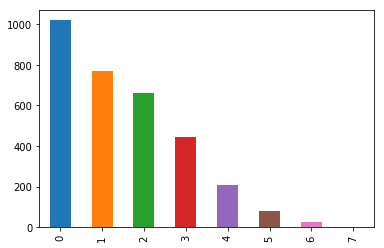

In [113]:
# Distributions are simmilar
display(DonaldTweets['ADJcnt'].value_counts().plot.bar())

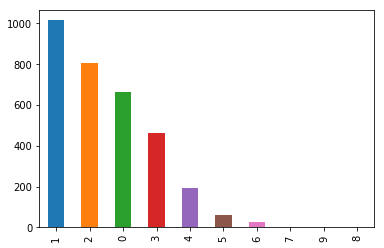

In [114]:
display(HillaryTweets['ADJcnt'].value_counts().plot.bar())